# TESTING DQN AGENT w/ MLP Policy (stablebaselines3) for custom enviroment solving (maze-like map/coverage)


In [1]:
import os
import numpy as np
import gymnasium as gym
from coverage_env import CoverageEnv
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pygame_renderer import PygameRenderer
import pygame

## Training DQN for *LEVEL 1*

In [ ]:
# instantiate a single env (you can wrap VecEnv for parallelism later)
env = CoverageEnv(seed=42)

# create the DQN model
model = DQN(
    policy="MlpPolicy",   # a simple MLP
    env=env,
    buffer_size=100000,
    learning_rate=1e-4,
    batch_size=32,
    gamma=0.99,
    verbose=1,
    tensorboard_log="logs/dqn_mlp_coverage_lvl0",
)

# train for 50k timesteps
model.learn(total_timesteps=500_000)

# save it
model.save("models/dqn_mlp_coverage_lvl0")


### PLOTING LEARNING CURVE FOR LEVEL 0

In [ ]:
# Path to the actual run folder, e.g., "DQN_1" inside your log directory
log_dir = "logs/dqn_mlp_coverage_lvl0"
run_id = os.listdir(log_dir)[0]  # e.g., "DQN_1"
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("DQN Learning Curve (Level 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------ # 

mean_reward, std_reward = evaluate_policy(
    model, 
    env, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

### PYGAME VIZUALIZATION FOR AGENT TRAINED ON LEVEL 0

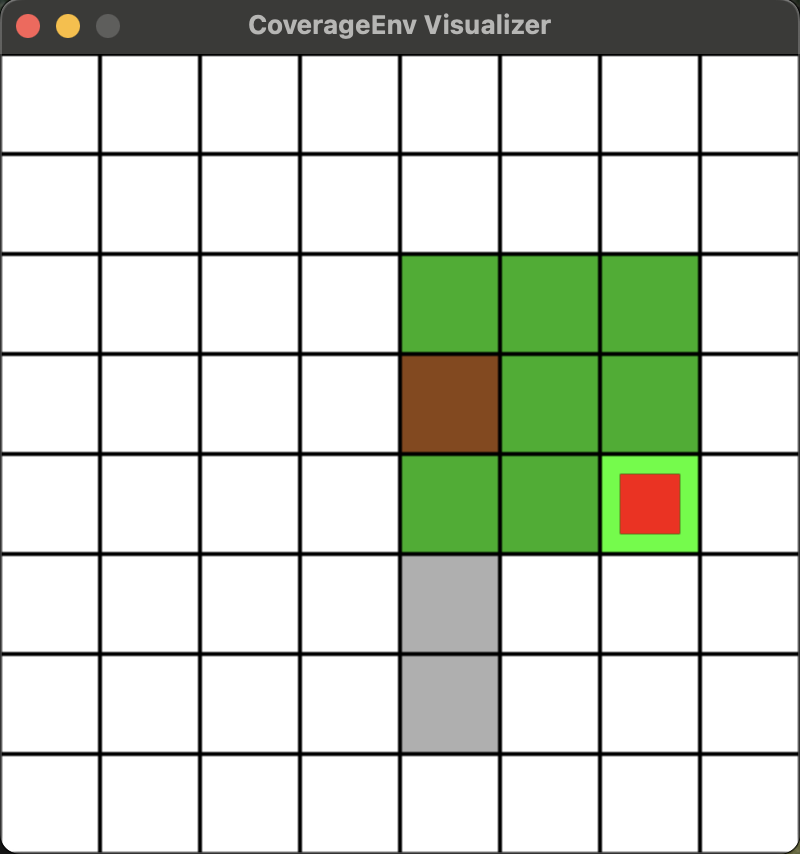

In [ ]:
# Load the trained model
model = DQN.load("models/dqn_mlp_coverage_lvl0")

# Create the environment for inference
env = CoverageEnv(seed=42, curriculum=0)
obs, _ = env.reset()

# Create the Pygame renderer
renderer = PygameRenderer(env)

done = False
while not done:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True
        elif event.type == pygame.KEYDOWN and event.key == pygame.K_q:
            done = True

    # Get action from the trained model
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)  
    obs, reward, terminated, truncated, _ = env.step(action)

    # Render environment
    renderer.render()

    if terminated or truncated:
        pygame.time.wait(10000) 
        done = True

renderer.close()

## Testing the model trained on level 0 on level 1 and seeing how it performs.

In [ ]:
# Instantiate the environment at curriculum level 1
env = CoverageEnv(seed=42, curriculum=1)

# Load the pretrained model from curriculum 0
model = DQN.load("models/dqn_mlp_coverage_lvl0.zip", env=env)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

### Can add the pygame vizualization here as well

### Training/Fine tuning the model from level 0 to level 1

In [2]:
# Create a new environment for curriculum level 1
env_1 = CoverageEnv(curriculum=1)

# Load the trained model and bind it to the new environment
model = DQN.load("models/dqn_mlp_coverage_lvl0.zip", env=env_1)

# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/dqn_mlp_coverage_lvl1")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/dqn_mlp_coverage_lvl0/DQN_5
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -79.2    |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3884     |
|    time_elapsed     | 0        |
|    total_timesteps  | 488      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.759    |
|    n_updates        | 125071   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4334     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1156     |
| tr

### Testing the model (now trained on level 0 and 1) on level 0 and 1

In [ ]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")

env_0 = CoverageEnv(curriculum=0)

mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 0: {mean_reward:.2f} ± {std_reward:.2f}")

# Can add vizualization here as well

/Users/pedropertusi/Desktop/reinforcement-learning/Coverage-Path-Planning/env/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Fine-tuned performance on level 1: 33.50 ± 48.14
Fine-tuned performance on level 0: -198.20 ± 3.20


#### yup, he unlearned the level 0, but learned the level 1

### Testing the model trained on level 0 and level 1 and seeing how it performs on level 2

In [ ]:
# Instantiate the environment at curriculum level 1
env = CoverageEnv(seed=42, curriculum=2)

# Load the pretrained model from curriculum 0
model = DQN.load("models/dqn_mlp_coverage_lvl1.zip", env=env)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

# Run one episode with render
obs, _ = env.reset()

print("starting state:")
env.render()
print("\n")

for i in range(env.max_steps):
    action_arr, _ = model.predict(obs, deterministic=True)
    action = int(action_arr)
    print("step:", i, "action:", action)

    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    print("\n")

    if terminated or truncated:
        break


### Training/Fine tuning the model from level 0 and 1 to level 2

In [ ]:
# Create a new environment for curriculum level 1
env = CoverageEnv(curriculum=2)

# Load the trained model and bind it to the new environment
model = DQN.load("models/dqn_mlp_coverage_lvl1.zip", env=env)

# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/dqn_mlp_coverage_lvl1")


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(
    model,
    env,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")


In [ ]:
# Run one episode with render
obs, _ = env.reset()

print("starting state:")
env.render()
print("\n")

for i in range(env.max_steps):
    action_arr, _ = model.predict(obs, deterministic=True)
    action = int(action_arr)
    print("step:", i, "action:", action)

    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    print("\n")

    if terminated or truncated:
        break

### Testing the model trained on level 0,1 and 2 seeing how it performs on level 3

In [ ]:
# Instantiate the environment at curriculum level 1
env = CoverageEnv(seed=42, curriculum=3)

# Load the pretrained model from curriculum 0
model = DQN.load("models/dqn_mlp_coverage_lvl1.zip", env=env)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

# Run one episode with render
obs, _ = env.reset()

print("starting state:")
env.render()
print("\n")

for i in range(env.max_steps):
    action_arr, _ = model.predict(obs, deterministic=True)
    action = int(action_arr)
    print("step:", i, "action:", action)

    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    print("\n")

    if terminated or truncated:
        break
